In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


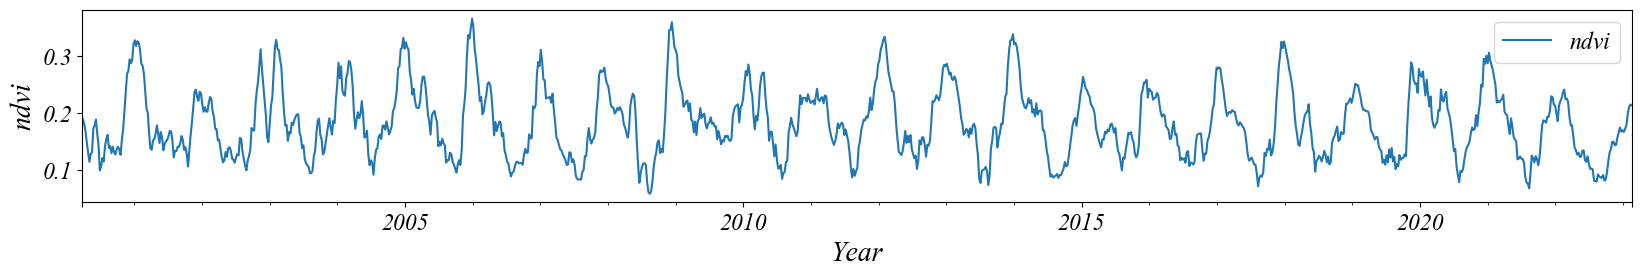

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

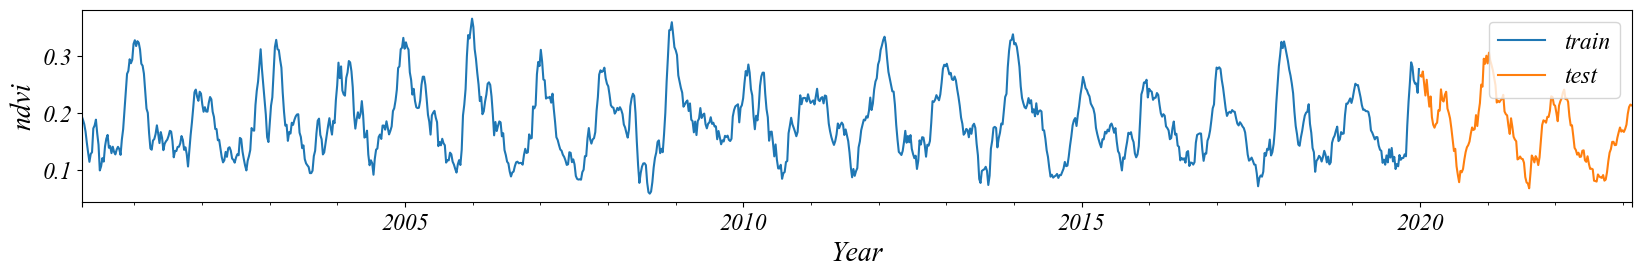

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

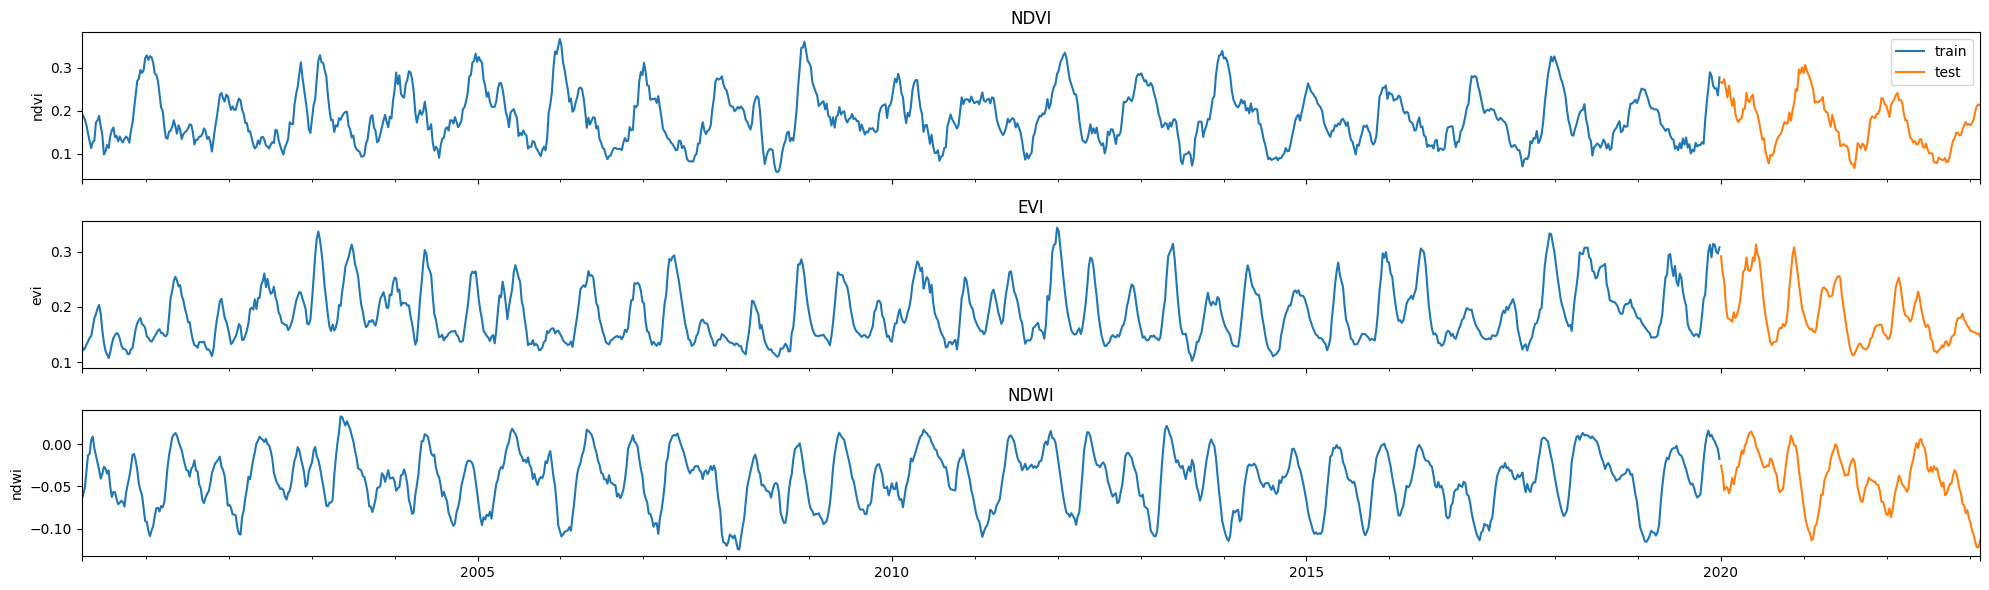

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### MLP-5

In [ ]:
# data must be split into input/output samples in order to train a model
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
#Scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
train_data=scaler.fit_transform(np.array(data_train))
test_data=scaler.fit_transform(np.array(data_test))
#print(df_train)

In [ ]:
# multivariate data preparation
from numpy import array
from numpy import hstack

in_seq1 = np.array(train_data[:,0])
in_seq2 = np.array(train_data[:,1])
out_seq = np.array(train_data[:,2])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
train_dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
in_seq1 = np.array(test_data[:,0])
in_seq2 = np.array(test_data[:,1])
out_seq = np.array(test_data[:,2])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
test_dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
lags = 5
# convert into input/output
X_train, y_train = split_sequences(train_dataset, lags)
X_test, y_test = split_sequences(test_dataset, lags)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_test = X_test.reshape((X_test.shape[0], n_input))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def MLP_model():
  model = Sequential()
  model.add(Dense(100, activation='relu', input_dim=n_input))
  model.add(Dense(3))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
# define the grid search parameters
batchSize = [10,20, 50,100,200]
epochs = [20,50,100]

In [ ]:
# create model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
model = KerasRegressor(build_fn=MLP_model)

In [ ]:
from sklearn.model_selection import GridSearchCV
#neurons = [30, 50, 100,128,150]
#optimizer = ['SGD', 'RMSprop', 'Adam']
parameter_grid = dict(batch_size=batchSize, epochs=epochs)

In [ ]:
grid = HalvingGridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
52/52 [==============================] - 1s 3ms/step - loss: 0.5313
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.1478
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0951
Epoch 4/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0795
Epoch 5/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 8/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 9/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 10/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0553
Epoch 11/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 12/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0516
Epoch 13/100
52/52 [=================

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.055385 using {'batch_size': 20, 'epochs': 100}
-0.127756 (0.017268) with: {'batch_size': 10, 'epochs': 20}
-0.092434 (0.031671) with: {'batch_size': 10, 'epochs': 50}
-0.077116 (0.014326) with: {'batch_size': 10, 'epochs': 100}
-0.179353 (0.007275) with: {'batch_size': 20, 'epochs': 20}
-0.102839 (0.018627) with: {'batch_size': 20, 'epochs': 50}
-0.083428 (0.021465) with: {'batch_size': 20, 'epochs': 100}
-0.289569 (0.022510) with: {'batch_size': 50, 'epochs': 20}
-0.132367 (0.017467) with: {'batch_size': 50, 'epochs': 50}
-0.105387 (0.026898) with: {'batch_size': 50, 'epochs': 100}
-0.389286 (0.099045) with: {'batch_size': 100, 'epochs': 20}
-0.199570 (0.043135) with: {'batch_size': 100, 'epochs': 50}
-0.105175 (0.015727) with: {'batch_size': 100, 'epochs': 100}
-0.370063 (0.080266) with: {'batch_size': 200, 'epochs': 20}
-0.222464 (0.052248) with: {'batch_size': 200, 'epochs': 50}
-0.119091 (0.006844) with: {'batch_size': 200, 'epochs': 100}
-0.076978 (0.010533) with: {'batc

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def MLP_model(neurons,optimizers):
  model = Sequential()
  model.add(Dense(neurons, activation='relu', input_dim=n_input))
  model.add(Dense(3))
  model.compile(optimizer=optimizers, loss='mse')
  return model

In [ ]:
# create model
model = KerasRegressor(build_fn=MLP_model, epochs=100, batch_size=20)
# define the grid search parameters
neurons = [30, 50, 100,128,150]
optimizer = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(neurons=neurons,optimizers=optimizer)
grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
52/52 [==============================] - 2s 5ms/step - loss: 0.3607
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 0.1359
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0938
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0781
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0702
Epoch 6/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0648
Epoch 7/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 8/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 9/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0562
Epoch 10/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0541
Epoch 11/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0519
Epoch 12/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0510
Epoch 13/100
52/52 [=================

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.056063 using {'neurons': 100, 'optimizers': 'Adam'}
-0.165646 (0.047927) with: {'neurons': 30, 'optimizers': 'SGD'}
-0.113469 (0.033870) with: {'neurons': 30, 'optimizers': 'RMSprop'}
-0.154219 (0.049273) with: {'neurons': 30, 'optimizers': 'Adam'}
-0.158680 (0.039736) with: {'neurons': 50, 'optimizers': 'SGD'}
-0.107355 (0.029539) with: {'neurons': 50, 'optimizers': 'RMSprop'}
-0.116635 (0.032015) with: {'neurons': 50, 'optimizers': 'Adam'}
-0.137852 (0.031151) with: {'neurons': 100, 'optimizers': 'SGD'}
-0.091889 (0.031150) with: {'neurons': 100, 'optimizers': 'RMSprop'}
-0.092991 (0.019625) with: {'neurons': 100, 'optimizers': 'Adam'}
-0.135471 (0.027823) with: {'neurons': 128, 'optimizers': 'SGD'}
-0.095491 (0.027339) with: {'neurons': 128, 'optimizers': 'RMSprop'}
-0.107704 (0.031716) with: {'neurons': 128, 'optimizers': 'Adam'}
-0.144097 (0.031736) with: {'neurons': 150, 'optimizers': 'SGD'}
-0.098196 (0.032908) with: {'neurons': 150, 'optimizers': 'RMSprop'}
-0.089239 (

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(3))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               1600      
                                                                 
 dense_8 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1,903
Trainable params: 1,903
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
history=model.fit(X_train, y_train, epochs=100,batch_size=20, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/100
47/47 [==============================] - 1s 8ms/step - loss: 0.4749 - val_loss: 0.2418
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2051 - val_loss: 0.1526
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.1350 - val_loss: 0.1209
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1076 - val_loss: 0.1040
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0937 - val_loss: 0.0930
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0848 - val_loss: 0.0858
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0783 - val_loss: 0.0811
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0734 - val_loss: 0.0779
Epoch 9/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0695 - val_loss: 0.0751
Epoch 10/100
47/47 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.0729
Epoch 11/

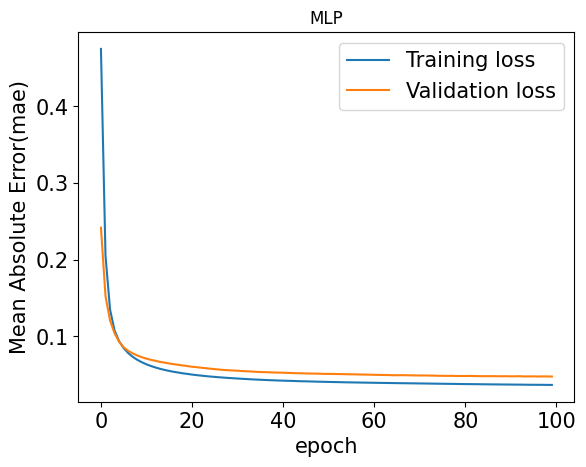

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('MLP')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('Mean Absolute Error(mae)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

In [ ]:
#train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [ ]:
#train_predict=scaler.inverse_transform(train_predict)
y_pred_future=scaler.inverse_transform(test_predict)

In [ ]:
y_pred_future=pd.DataFrame(y_pred_future)

In [ ]:
y_pred_future

,0,1,2
0,0.228946,0.178002,-0.056318
1,0.256403,0.171954,-0.058696
2,0.244746,0.178509,-0.049914
3,0.215122,0.187997,-0.034641
4,0.232983,0.198958,-0.044544
...,...,...,...
154,0.171829,0.148693,-0.104200
155,0.180892,0.148891,-0.105617
156,0.198756,0.148494,-0.116098
157,0.209803,0.145469,-0.121173


In [ ]:
y_pred_future.shape

(159, 3)

In [ ]:
datap = data_test[-(y_pred_future.shape[0]):]
datap

,ndvi,evi,ndwi
date,,,
2020-02-06,0.258460,0.178165,-0.058288
2020-02-13,0.233002,0.176298,-0.051384
2020-02-20,0.211088,0.173098,-0.039927
2020-02-27,0.228980,0.190412,-0.047470
2020-03-05,0.192494,0.180041,-0.037441
...,...,...,...
2023-01-19,0.179294,0.154222,-0.106630
2023-01-26,0.198209,0.153708,-0.115402
2023-02-02,0.210345,0.151326,-0.121956


In [ ]:
y_pred_future['date']=datap.index
y_pred_future=y_pred_future.set_index('date')

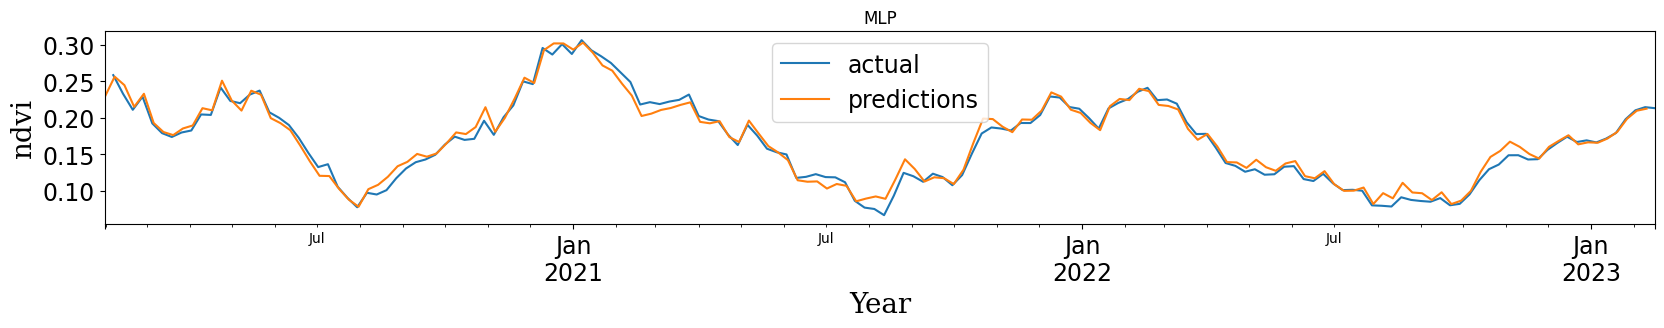

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.ndvi.plot(ax=ax, label='actual', title='MLP')
y_pred_future[0].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

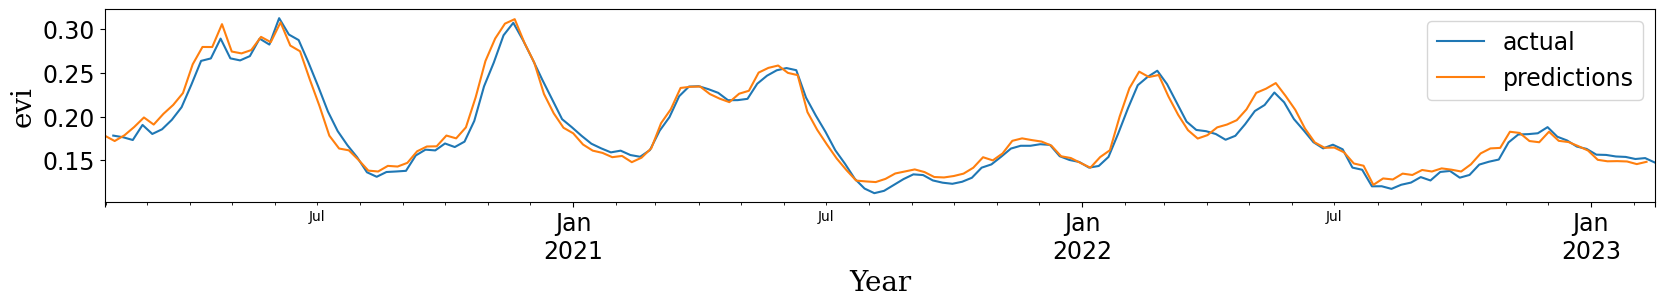

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.evi.plot(ax=ax, label='actual')
y_pred_future[1].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

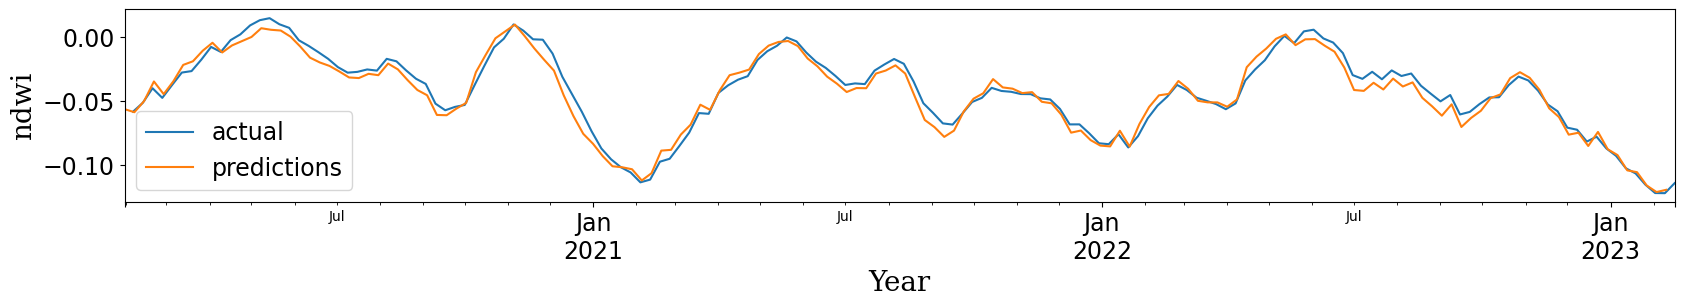

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.ndwi.plot(ax=ax, label='actual')
y_pred_future[2].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test[0],test_predict[0])
mse = mean_squared_error(y_test[0],test_predict[0])
r2 = r2_score(y_test[0],test_predict[0])
rmse = math.sqrt(mean_squared_error(y_test[0],test_predict[0]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.1933955440055547
MSE is 0.08907587587191912
RMSE is 0.29845581896139856
R2 is 0.886415243520011


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test[1],test_predict[1])
mse = mean_squared_error(y_test[1],test_predict[1])
r2 = r2_score(y_test[1],test_predict[1])
rmse = math.sqrt(mean_squared_error(y_test[1],test_predict[1]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.244272347083884
MSE is 0.07651896844817238
RMSE is 0.2766206218780017
R2 is 0.8024352854588718


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test[2],test_predict[2])
mse = mean_squared_error(y_test[2],test_predict[2])
r2 = r2_score(y_test[2],test_predict[2])
rmse = math.sqrt(mean_squared_error(y_test[2],test_predict[2]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.3399101854486477
MSE is 0.15313451009398107
RMSE is 0.3913240474261466
R2 is 0.018011510051939017


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test,test_predict)
mse = mean_squared_error(y_test,test_predict)
r2 = r2_score(y_test,test_predict)
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.17633002091544628
MSE is 0.05009630021048315
RMSE is 0.22382202798313475
R2 is 0.9490650191024527


#### forcast

In [ ]:
X_test.shape

(159, 15)

In [ ]:
#Taking the last 500 values as input to predic future values
x_input=X_test[-1:]
x_input.shape

(1, 15)

In [ ]:
x_tempinput=x_input
x_tempinput

array([[ 2.55258834e-03, -6.18226973e-01, -1.95764913e+00,
         1.34150283e-01, -6.54522463e-01, -2.08921355e+00,
         4.62896221e-01, -6.65059864e-01, -2.37365211e+00,
         6.73841444e-01, -7.13857019e-01, -2.58618167e+00,
         7.49323895e-01, -6.92574187e-01, -2.58952894e+00]])

In [ ]:
# demonstrate prediction for next 5 year
from numpy import array
from numpy import zeros, newaxis

lst_output=[]

for i in range(0,300):
        #print(temp_input)
        x_input=x_tempinput
        print("{} input: \n\n{}".format(i,x_input))
        yhat = model.predict(x_input)
        print("\n{} th output: {}\n\n\n".format(i,yhat))

        x_tempinput=np.append(x_tempinput,yhat)
        x_tempinput=x_tempinput[3:]
        x_tempinput = x_tempinput[newaxis,:]
        lst_output.extend(yhat.tolist())

0 input: 

[[ 2.55258834e-03 -6.18226973e-01 -1.95764913e+00  1.34150283e-01
  -6.54522463e-01 -2.08921355e+00  4.62896221e-01 -6.65059864e-01
  -2.37365211e+00  6.73841444e-01 -7.13857019e-01 -2.58618167e+00
   7.49323895e-01 -6.92574187e-01 -2.58952894e+00]]
1/1 [==============================] - 0s 39ms/step

0 th output: [[ 0.71310383 -0.779887   -2.50359   ]]



1 input: 

[[ 0.13415028 -0.65452246 -2.08921355  0.46289622 -0.66505986 -2.37365211
   0.67384144 -0.71385702 -2.58618167  0.74932389 -0.69257419 -2.58952894
   0.71310383 -0.77988702 -2.50359011]]
1/1 [==============================] - 0s 38ms/step

1 th output: [[ 0.6130377 -0.8901294 -2.3673477]]



2 input: 

[[ 0.46289622 -0.66505986 -2.37365211  0.67384144 -0.71385702 -2.58618167
   0.74932389 -0.69257419 -2.58952894  0.71310383 -0.77988702 -2.50359011
   0.61303771 -0.89012939 -2.36734772]]
1/1 [==============================] - 0s 40ms/step

2 th output: [[ 0.44517168 -1.036348   -2.2500618 ]]



3 input: 

[[ 0.6

In [ ]:
print(lst_output)

[[0.7131038308143616, -0.7798870205879211, -2.5035901069641113], [0.6130377054214478, -0.8901293873786926, -2.3673477172851562], [0.44517168402671814, -1.0363479852676392, -2.2500617504119873], [0.1990780532360077, -1.237028956413269, -2.087711811065674], [-0.031239284202456474, -1.434752106666565, -1.8722718954086304], [-0.2232997566461563, -1.6274904012680054, -1.5860519409179688], [-0.3455384373664856, -1.7226204872131348, -1.2142664194107056], [-0.32624536752700806, -1.6234172582626343, -0.8124620914459229], [-0.2088341861963272, -1.3394936323165894, -0.44190579652786255], [-0.06071461737155914, -0.8723999857902527, -0.08298278599977493], [0.0983426570892334, -0.31944817304611206, 0.27625948190689087], [0.2885986566543579, 0.25191932916641235, 0.5150644183158875], [0.4972752630710602, 0.7576090097427368, 0.6361618638038635], [0.710827648639679, 1.1534560918807983, 0.6283464431762695], [0.9331812262535095, 1.395242691040039, 0.5064634680747986], [1.1321516036987305, 1.50202620029449

In [ ]:
len(lst_output)

300

In [ ]:
prediction=np.array(lst_output)

In [ ]:
train_date=pd.to_datetime(data.index)
train_date

DatetimeIndex(['2000-03-23', '2000-03-30', '2000-04-06', '2000-04-13',
               '2000-04-20', '2000-04-27', '2000-05-04', '2000-05-11',
               '2000-05-18', '2000-05-25',
               ...
               '2022-12-15', '2022-12-22', '2022-12-29', '2023-01-05',
               '2023-01-12', '2023-01-19', '2023-01-26', '2023-02-02',
               '2023-02-09', '2023-02-16'],
              dtype='datetime64[ns]', name='date', length=1196, freq='7D')

In [ ]:
n_week_for_prediction=300  #let us predict 1 year

predict_period_dates = pd.date_range(list(train_date)[-1], periods=n_week_for_prediction, freq='7D').tolist()
print(predict_period_dates)


[Timestamp('2023-02-16 00:00:00', freq='7D'), Timestamp('2023-02-23 00:00:00', freq='7D'), Timestamp('2023-03-02 00:00:00', freq='7D'), Timestamp('2023-03-09 00:00:00', freq='7D'), Timestamp('2023-03-16 00:00:00', freq='7D'), Timestamp('2023-03-23 00:00:00', freq='7D'), Timestamp('2023-03-30 00:00:00', freq='7D'), Timestamp('2023-04-06 00:00:00', freq='7D'), Timestamp('2023-04-13 00:00:00', freq='7D'), Timestamp('2023-04-20 00:00:00', freq='7D'), Timestamp('2023-04-27 00:00:00', freq='7D'), Timestamp('2023-05-04 00:00:00', freq='7D'), Timestamp('2023-05-11 00:00:00', freq='7D'), Timestamp('2023-05-18 00:00:00', freq='7D'), Timestamp('2023-05-25 00:00:00', freq='7D'), Timestamp('2023-06-01 00:00:00', freq='7D'), Timestamp('2023-06-08 00:00:00', freq='7D'), Timestamp('2023-06-15 00:00:00', freq='7D'), Timestamp('2023-06-22 00:00:00', freq='7D'), Timestamp('2023-06-29 00:00:00', freq='7D'), Timestamp('2023-07-06 00:00:00', freq='7D'), Timestamp('2023-07-13 00:00:00', freq='7D'), Timestamp

In [ ]:
predict_period_dates = pd.to_datetime(predict_period_dates)

In [ ]:
predict_period_dates

DatetimeIndex(['2023-02-16', '2023-02-23', '2023-03-02', '2023-03-09',
               '2023-03-16', '2023-03-23', '2023-03-30', '2023-04-06',
               '2023-04-13', '2023-04-20',
               ...
               '2028-09-07', '2028-09-14', '2028-09-21', '2028-09-28',
               '2028-10-05', '2028-10-12', '2028-10-19', '2028-10-26',
               '2028-11-02', '2028-11-09'],
              dtype='datetime64[ns]', length=300, freq=None)

In [ ]:
y_pred_future=prediction

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
y_pred_future=np.array(y_pred_future)
y_pred_future = y_pred_future.reshape(300,3)

In [ ]:
y_pred_future = scaler.inverse_transform(y_pred_future)

In [ ]:
df_forecast = pd.DataFrame(y_pred_future, columns = ['ndvi_pred','evi_pred','ndwi_pred'])
df_forecast

,ndvi_pred,evi_pred,ndwi_pred
0,0.212604,0.148104,-0.119409
1,0.206847,0.142723,-0.115207
2,0.197189,0.135587,-0.111591
3,0.183030,0.125793,-0.106584
4,0.169779,0.116143,-0.099940
...,...,...,...
295,0.264806,0.211179,-0.052322
296,0.264806,0.211179,-0.052322
297,0.264806,0.211179,-0.052322
298,0.264806,0.211179,-0.052321


In [ ]:
df_forcdate = pd.DataFrame({'Date':np.array(forecast_dates).flatten()})
df_forcdate

,Date
0,2023-02-16
1,2023-02-23
2,2023-03-02
3,2023-03-09
4,2023-03-16
...,...
295,2028-10-12
296,2028-10-19
297,2028-10-26
298,2028-11-02


In [ ]:
df_forecast['Date'] = df_forcdate['Date']
df_forecast=df_forecast.set_index('Date')
df_forecast.head()

,ndvi_pred,evi_pred,ndwi_pred
Date,,,
2023-02-16,0.212604,0.148104,-0.119409
2023-02-23,0.206847,0.142723,-0.115207
2023-03-02,0.197189,0.135587,-0.111591
2023-03-09,0.183030,0.125793,-0.106584
2023-03-16,0.169779,0.116143,-0.099940


Text(0, 0.5, 'NDVI')

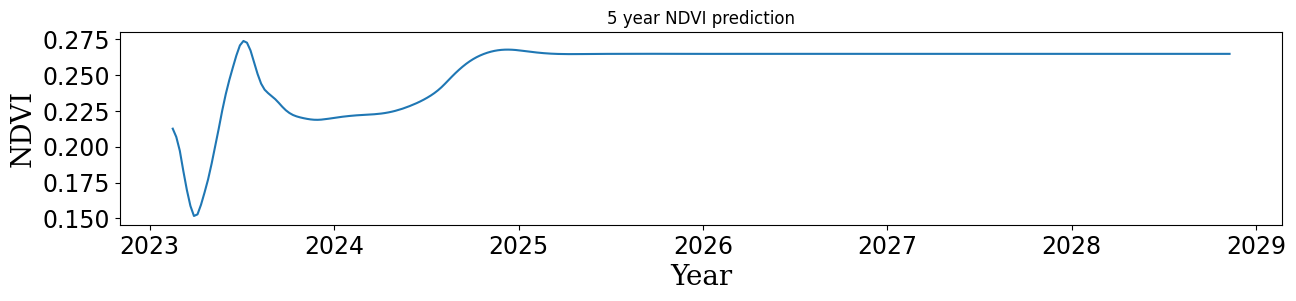

In [ ]:
#df_forecast['SPI_pred'].plot(figsize=(10, 2))

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(15, 2.5))
df_forecast['ndvi_pred'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)
#ax.legend();

Text(0, 0.5, 'NDVI')

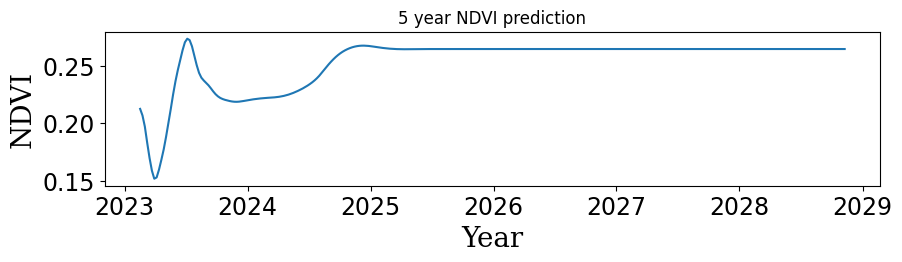

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['ndvi_pred'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)

Text(0, 0.5, 'EVI')

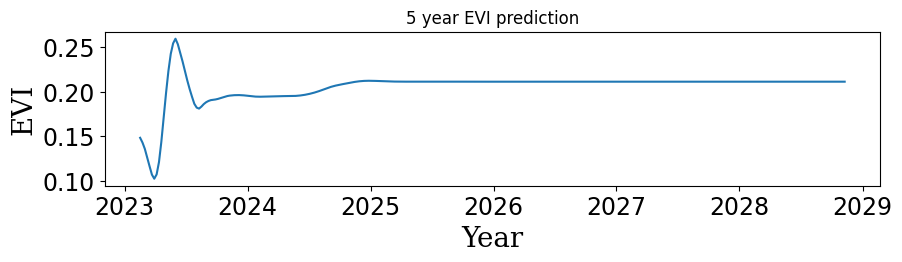

In [ ]:
#df_forecast['SPI_pred'].plot(figsize=(10, 2))

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['evi_pred'].plot(ax=ax, label='ndvi',title='5 year EVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)

Text(0, 0.5, 'NDWI')

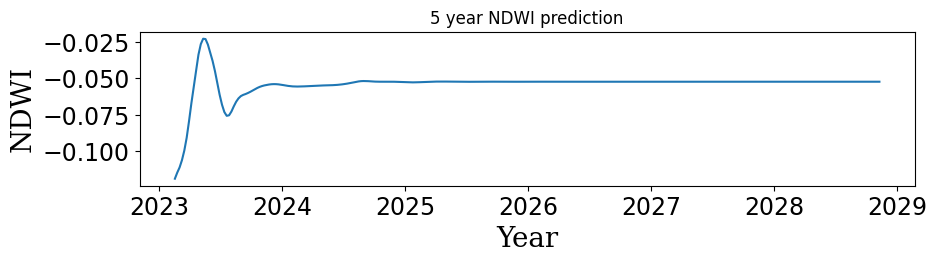

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['ndwi_pred'].plot(ax=ax, label='ndvi',title='5 year NDWI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)